# **Face Recognition**

Facial Recognition System is a technology capable of matching a human face from a digital image or a video frame against a database of faces, typically employed to authenticate users through ID verification services, works by pinpointing and measuring facial features from a given image.

We'll be building a face recognition model that uses Siamese Networks to give us a distance value that indicates whether 2 images are same or different.

The Dataset
We'll be using the Extracted Faces from face-recognition-dataset, which is derived from the LFW Dataset. The Extracted Faces contains faces extracted from the base images using Haar-Cascade Face-Detection (CV2).

* The dataset contains 1324 different individuals, with 2-50 images per person.
* The images are of size (128,128,3) and are encoded in RGB.
* Each folder and image is named with a number, i.e 0.jpg, 1.jpg

In [1]:
import os
import cv2

import time
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

import seaborn as sns
import matplotlib.pyplot as plt
tf.__version__, np.__version__

('2.6.2', '1.20.3')

## Reading the Dataset
We're reading the folders and splitting them into train and test set for training purposes.

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
# Setting random seeds to enable consistency while testing.
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

plant='Apple'
x=0
ROOT = "/kaggle/input/cv-project-dataset/Project Data/Train/images"
ROOT_T='/kaggle/input/cv-project-dataset/Project Data/Val/images'
def read_image(index,dir):
    path = os.path.join(dir,index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(128,128))
    # image = image / 255
    
    
    return image

In [4]:
def split_dataset(directory):
    folders = os.listdir(directory)
    num_train = int(len(folders))
    
    random.shuffle(folders)
    
    list= {}    
    # Creating Train-list
    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        list[folder] = num_files
    return list

train_list= split_dataset(ROOT)
test_list = split_dataset(ROOT_T)

print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", train_list)

print("\nTest List:", test_list)



Length of training list: 33
Length of testing list : 33

Test List: {'Corn_(maize)___Northern_Leaf_Blight': 40, 'Tomato___Spider_mites Two-spotted_spider_mite': 40, 'Tomato___Target_Spot': 40, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 40, 'Apple___Black_rot': 40, 'Tomato___Bacterial_spot': 40, 'Grape___healthy': 40, 'Corn_(maize)___Common_rust_': 40, 'Apple___Apple_scab': 40, 'Grape___Black_rot': 40, 'Pepper,_bell___healthy': 40, 'Peach___healthy': 40, 'Tomato___Tomato_mosaic_virus': 40, 'Strawberry___Leaf_scorch': 40, 'Tomato___Septoria_leaf_spot': 40, 'Tomato___Leaf_Mold': 40, 'Peach___Bacterial_spot': 40, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 40, 'Potato___healthy': 40, 'Tomato___Early_blight': 40, 'Tomato___healthy': 40, 'Grape___Esca_(Black_Measles)': 40, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 40, 'Cherry_(including_sour)___Powdery_mildew': 40, 'Tomato___Late_blight': 40, 'Corn_(maize)___healthy': 40, 'Potato___Late_blight': 40, 'Apple___healthy': 40, 'Cherr

## Creating Triplets
We use the train and test list to create triplets of (anchor, postive, negative) face data, where positive is the same person and negative is a different person than anchor.

In [5]:
import os
import random

def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        # Retrieve the actual file names and limit to max_files
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files - 1):
            for j in range(i + 1, num_files):
                # Anchor and positive use actual file names
                anchor = (folder, files[i])
                positive = (folder, files[j])

                # Select a negative example from a different folder
                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_files = os.listdir(os.path.join(directory, neg_folder))
                neg_file = random.choice(neg_files)
                negative = (neg_folder, neg_file)

                triplets.append((anchor, positive, negative))

        # Shuffle triplets for better randomness
        random.shuffle(triplets)

    return triplets

In [6]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT_T, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 1485
Number of testing triplets : 1485

Examples of triplets:
(('Apple___Apple_scab', '6b6b2140-bb67-4342-adad-8cba97a5ecbe___FREC_Scab 3388.JPG'), ('Apple___Apple_scab', '376aaef3-8649-43aa-89f8-166bd349a3d3___FREC_Scab 3064.JPG'), ('Corn_(maize)___Common_rust_', '0bfffc66-fbe5-4768-b781-f2209b90798d___RS_Rust 2379.JPG'))
(('Cherry_(including_sour)___healthy', 'c9c77d66-5410-4974-be51-16a22f16a1e7___JR_HL 3995.JPG'), ('Cherry_(including_sour)___healthy', '141d550c-95f0-45eb-8196-8886f0b1acd6___JR_HL 4000.JPG'), ('Tomato___Leaf_Mold', '93608d6e-7511-4388-88c1-ef45b754e9c2___Crnl_L.Mold 6580.JPG'))
(('Apple___Black_rot', '977c9b03-47f2-412d-a73d-7e647e973336___JR_FrgE.S 2887.JPG'), ('Apple___Black_rot', 'f9b7fc98-caee-4bb1-ae7b-1e9981ba6d72___JR_FrgE.S 2990.JPG'), ('Tomato___Septoria_leaf_spot', '7a74368f-379b-4bb8-a8cb-a21b86ef8d63___JR_Sept.L.S 2590.JPG'))
(('Pepper,_bell___Bacterial_spot', '4614ed01-e120-4ae9-8f13-028fa8297873___JR_B.Spot 8985.JPG'), ('Pe

## Creating Batch-Generator¶
Creating a Batch-Generator that converts the triplets passed into batches of face-data and preproccesses it before returning the data into seperate lists.

Parameters:

* Batch_size: Batch_size of the data to return
* Preprocess: Whether to preprocess the data or not

In [7]:
def get_batch(triplet_list,dir, batch_size=256, preprocess=True):
    batch_steps = len(triplet_list)//batch_size
    
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(a,dir))
            positive.append(read_image(p,dir))
            negative.append(read_image(n,dir))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

## Plotting the Data
Plotting the data generated from get_batch() to see the results

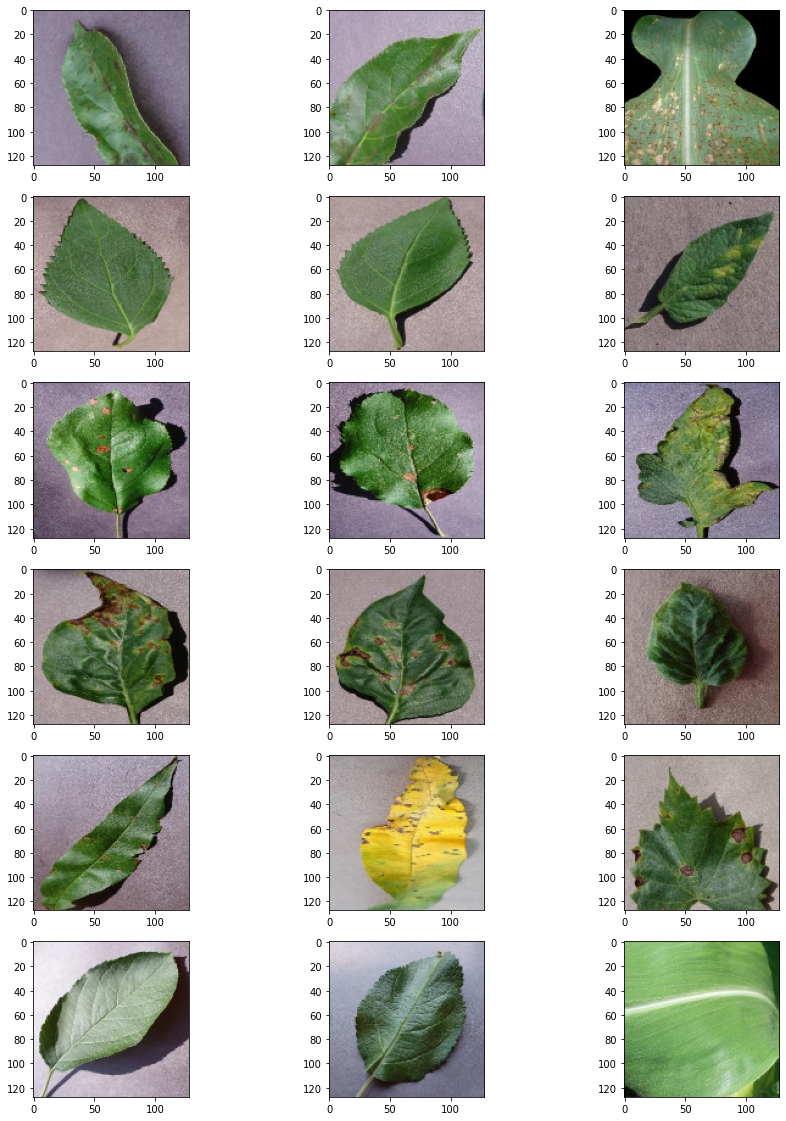

In [8]:
num_plots = 6

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for x in get_batch(train_triplet,ROOT, batch_size=num_plots, preprocess=False):
    a,p,n = x
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 1].imshow(p[i])
        axes[i, 2].imshow(n[i])
        i+=1
    break

## Creating the Model
Unlike a conventional CNN, the Siamese Network does not classify the images into certain categories or labels, rather it only finds out the distance between any two given images. If the images have the same label, then the network should learn the parameters, i.e. the weights and the biases in such a way that it should produce a smaller distance between the two images, and if they belong to different labels, then the distance should be larger

Siamese Network Image
![](https://miro.medium.com/max/2000/1*05hUCDHhnl4hdjqvdVTHtw.png)

In [9]:
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNet,EfficientNetB0

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG19,ResNet152,InceptionV3,InceptionResNetV2


## Encoder
The Encoder is responsible for converting the passed images into their feature vectors. We're using a pretrained model, Xception model which is based on Inception_V3 model. By using transfer learning, we can significantly reduce the training time and size of the dataset.

The Model is connected to Fully Connected (Dense) layers and the last layer normalises the data using L2 Normalisation. (L2 Normalisation is a technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1)

In [10]:
def get_encoder(input_shape):
    
    """ Returns the image encoding model """
    tf.keras.backend.clear_session()
    # MobileNet(weights='imagenet', include_top=False, input_shape=input_shape,pooling='avg')
    pretrained_model =base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape,pooling='avg',)
    
    for layer in pretrained_model.layers[:200]:  # Freeze the first 200 layers
        layer.trainable = False

    encode_model = Sequential([
        pretrained_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="Encode_Model")
    return encode_model

Siamese Network
We're creating a Siamese Network that takes 3 input images, (anchor, postive, negative) and uses the encoder above to encode the images to their feature vectors. Those features are passed to a distance layer which computes the distance between (anchor, positive) and (anchor, negative) pairs.

We'll be defining a custom layer to compute the distance.

Distance Formula:

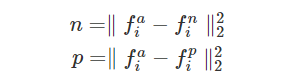

In [11]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)
    

def get_siamese_network(input_shape = (128, 128, 3)):
    encoder = get_encoder(input_shape)
    
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    # encoded_a = encoder(anchor_input)
    # encoded_p = encoder(positive_input)
    # encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

219070464/219055592 [==============================] - 6s 0us/step
Model: "Siamese_Network"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Anchor_Input (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Positive_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Negative_Input (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Encode_Model (Sequential)       (None, 256)          55257056    Anchor_Input[0][0]               
                 

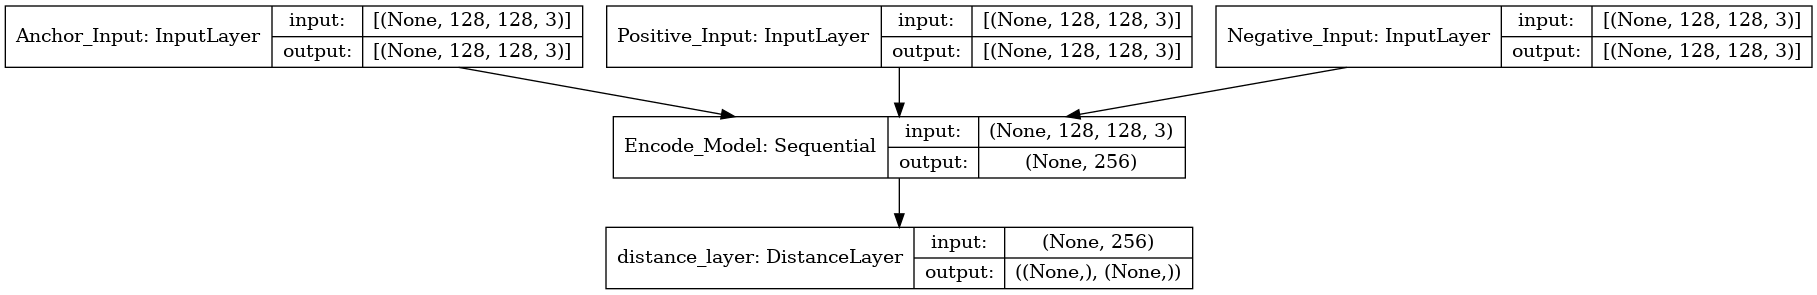

In [12]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

## Putting everything together
We now need to implement a model with custom training loop and loss function so we can compute the triplet loss using the three embeddings produced by the Siamese network.

We'll create a Mean metric instance to track the loss of the training process.

Triplet Loss Function:

### ![](https://miro.medium.com/max/1838/0*AX2TSZNk19_gDgTN.png)

In [13]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker]

In [14]:
siamese_model = SiameseModel(siamese_network)

optimizer = Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

## Training the Model
We'll now be training the siamese_model on batches of triplets. We'll print the training loss, along with additional metrics from testing every epoch. The model weights will also be saved whenever it outperforms the previous max_accuracy.

We're hoping to collect more metrics about the model to evaluate how to increase the accuracy of the model. The epochs have been set to avoid going over Kaggle's time constraint.

### Test Function
test_on_triplets() function will be responsible for testing the model on test_triplets. It'll collect metrics (accuracy, means, stds) by predicting on the train data. We'll also be printing the Accuracy of the model after testing.

In [15]:
def test_on_triplets(batch_size=256):
    pos_scores, neg_scores = [], []

    for data in get_batch(test_triplet,ROOT_T, batch_size=batch_size):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    print(f"Accuracy on test = {accuracy:.5f}")
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [16]:
save_all = False
epochs = 15
batch_size = 32

max_acc = 0
train_loss = []
test_metrics = []

for epoch in range(1, epochs+1):
    t = time.time()
    
    # Training the model on train data
    epoch_loss = []
    for data in get_batch(train_triplet,ROOT, batch_size=batch_size):
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)

    print(f"\nEPOCH: {epoch} \t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    # Testing the model on test data
    metric = test_on_triplets(batch_size=batch_size)
    test_metrics.append(metric)
    accuracy = metric[0]
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        # siamese_model.save_weights("siamese_model")
        max_acc = accuracy

# Saving the model after all epochs run
# siamese_model.save_weights("siamese_model-final")


EPOCH: 1 	 (Epoch done in 95 sec)
Loss on train    = 0.43810
Accuracy on test = 0.91111

EPOCH: 2 	 (Epoch done in 27 sec)
Loss on train    = 0.14303
Accuracy on test = 0.90034

EPOCH: 3 	 (Epoch done in 27 sec)
Loss on train    = 0.12519
Accuracy on test = 0.89562

EPOCH: 4 	 (Epoch done in 27 sec)
Loss on train    = 0.08811
Accuracy on test = 0.92593

EPOCH: 5 	 (Epoch done in 27 sec)
Loss on train    = 0.05229
Accuracy on test = 0.92795

EPOCH: 6 	 (Epoch done in 27 sec)
Loss on train    = 0.04158
Accuracy on test = 0.92458

EPOCH: 7 	 (Epoch done in 28 sec)
Loss on train    = 0.03328
Accuracy on test = 0.90101

EPOCH: 8 	 (Epoch done in 27 sec)
Loss on train    = 0.02372
Accuracy on test = 0.94209

EPOCH: 9 	 (Epoch done in 26 sec)
Loss on train    = 0.03283
Accuracy on test = 0.93939

EPOCH: 10 	 (Epoch done in 27 sec)
Loss on train    = 0.03049
Accuracy on test = 0.91515

EPOCH: 11 	 (Epoch done in 27 sec)
Loss on train    = 0.02804
Accuracy on test = 0.91313

EPOCH: 12 	 (Epoch

## Using the Model
Now that we've finished training our model, we need to extract the encoder so that we can use it to encode images and then get use the feature vectors to compute the distance between those images.

We'll also be saving the encoder for later use.

In [17]:
def extract_encoder(model):
    encoder = get_encoder((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.save_weights("encoder")
encoder.save("last_encoder(90%_test).h5")
encoder.summary()

#chromadb

Model: "Encode_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization_203 (Bat (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
lambda (Lambda)              (None, 256)               0         
Total params: 55,257,056
Trainable params: 53,860,592
Non-trainable params: 1,396,464
__________________________________

## Classify Images
To compute the distance between the encodings of the images, we'll be using distance formula. Distance over a certain threshold to be "different" and below the threshold as "same".

In [18]:
def classify_images(face_list1, face_list2, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.86328125



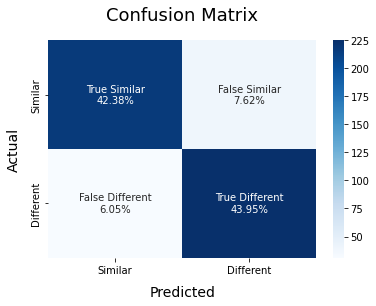

In [19]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet,ROOT_T, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p))
    neg_list = np.append(neg_list, classify_images(a, n))
    break

ModelMetrics(pos_list, neg_list)

In [20]:

'''
resize image to 128,128...

folder = cls.split("___")[0]
if label == folder :

images = []
labels = []

# Loop through subfolders and images
for subfolder in os.listdir(parent_dir):
    subfolder_path = os.path.join(parent_dir, subfolder)

    if os.path.isdir(subfolder_path):
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                image = cv2.imread(file_path)
                if image is not None:
                    image_resized = cv2.resize(image, (128, 128))  # Resize image
                    images.append(image_resized)
                    labels.append(subfolder)  # The subfolder name can be the label
                    
# Convert lists to numpy arrays (if needed for model input)
images = np.array(images)
labels = np.array(labels)
for image in images :
    

    def classify_images(image, given_image, threshold=1.3):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


'''
# train_dir=f'/kaggle/working/cv-project-dataset/Train/images/{label}'



'\nresize image to 128,128...\n\nfolder = cls.split("___")[0]\nif label == folder :\n\nimages = []\nlabels = []\n\n# Loop through subfolders and images\nfor subfolder in os.listdir(parent_dir):\n    subfolder_path = os.path.join(parent_dir, subfolder)\n\n    if os.path.isdir(subfolder_path):\n        for file_name in os.listdir(subfolder_path):\n            file_path = os.path.join(subfolder_path, file_name)\n\n            if file_name.endswith((\'.jpg\', \'.jpeg\', \'.png\')):\n                image = cv2.imread(file_path)\n                if image is not None:\n                    image_resized = cv2.resize(image, (128, 128))  # Resize image\n                    images.append(image_resized)\n                    labels.append(subfolder)  # The subfolder name can be the label\n                    \n# Convert lists to numpy arrays (if needed for model input)\nimages = np.array(images)\nlabels = np.array(labels)\nfor image in images :\n    \n\n    def classify_images(image, given_image, 

In [21]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import os

def classify_images(face_list1, face_list2, threshold=1.2):
    """
    Compares two images using the encoder model and returns predictions.
    """
    # Get encodings for the passed images
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    # Calculate the distance between encodings
    distance = np.sum(np.square(tensor1 - tensor2), axis=-1)

    # Prediction: 0 if similar, 1 if dissimilar
    prediction = np.where(distance <= threshold, 0, 1)
    return prediction

# Define label and folder paths
label = 'Corn'
folder_path = f'/kaggle/input/renamed-cv-dataset/renamed_data/Val/{label}'
target_image_path = '/kaggle/input/renamed-cv-dataset/renamed_data/Train/Corn/Corn_(maize)___Common_rust_/17.jpg'

# Load and preprocess the target image
target_image = cv2.imread(target_image_path)
if target_image is None:
    raise ValueError(f"Target image at {target_image_path} could not be loaded.")

# Resize and normalize target image
target_resized = cv2.resize(target_image, (128, 128))
target_normalized = target_resized / 255.0  # Normalize pixel values to [0, 1]
target_batch = np.expand_dims(target_normalized, axis=0)  # Add batch dimension

# Initialize a dictionary to store results per subfolder
comparison_results = {}

# Loop through all subfolders and process images
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)

    if os.path.isdir(subfolder_path):  # Ensure it's a directory
        # Initialize subfolder results
        comparison_results[subfolder] = []
        
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)

            # Check if it's an image file
            if file_name.endswith(('.jpg', '.jpeg', '.png')):
                # Load the image
                image = cv2.imread(file_path)
                if image is not None:
                    # Resize and normalize the image
                    image_resized = cv2.resize(image, (128, 128))
                    image_normalized = image_resized / 255.0
                    image_batch = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

                    # Compare target image with the current image
                    pred = classify_images(target_batch, image_batch)

                    # Append the result
                    comparison_results[subfolder].append(pred[0])  # Save prediction for the subfolder
                else:
                    print(f"Warning: Image at {file_path} could not be loaded.")

# Calculate and print average similarity for each subfolder
avg_similarity = {}  # Initialize dictionary to store average similarity for each subfolder

for subfolder, predictions in comparison_results.items():
    if predictions:
        # Calculate average similarity (percentage of images classified as similar)
        similarity_count = predictions.count(0)  # Count 'similar' predictions (0)
        total_images = len(predictions)
        average_similarity = (similarity_count / total_images) * 100
        avg_similarity[subfolder] = average_similarity  # Directly store the value
        print(f"Subfolder: {subfolder} , Average Similarity: {average_similarity:.2f}% , Total Images: {total_images}")
    else:
        print(f"Subfolder: {subfolder} | No images found to compare.")

# Find and print the subfolder with the maximum average similarity
if avg_similarity:
    max_subfolder = max(avg_similarity, key=avg_similarity.get)
    max_similarity = avg_similarity[max_subfolder]
    print(f"Subfolder with Max Average Similarity: {max_subfolder} , Average Similarity: {max_similarity:.2f}%")
else:
    print("No subfolders with images to compare.")


Subfolder: Corn_(maize)___Northern_Leaf_Blight , Average Similarity: 40.00% , Total Images: 10
Subfolder: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot , Average Similarity: 70.00% , Total Images: 10
Subfolder: Corn_(maize)___Common_rust_ , Average Similarity: 100.00% , Total Images: 10
Subfolder: Corn_(maize)___healthy , Average Similarity: 0.00% , Total Images: 10
Subfolder with Max Average Similarity: Corn_(maize)___Common_rust_ , Average Similarity: 100.00%


In [22]:
# import os
# import numpy as np
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.inception_v3 import preprocess_input
# from sklearn.metrics.pairwise import cosine_similarity

# model = load_model('E:/cv/siames_30/siamese_model_weights.h5')

# test_dir = 'E:/cv/test_reco'
# reference_dir = 'E:/cv/Product Recoginition/Training Data'
# reference_images = {}

# correct_predictions = 0
# total_predictions = 0
# class_count = 0

# for class_dir in os.listdir(reference_dir):
#     class_path = os.path.join(reference_dir, class_dir)
#     if os.path.isdir(class_path):
#         class_count += 1

#         for img_filename in os.listdir(class_path):
#             reference_image_path = os.path.join(class_path, img_filename)
#             reference_img = image.load_img(reference_image_path, target_size=(128, 128))
#             reference_img_array = image.img_to_array(reference_img)
#             reference_img_array = np.expand_dims(reference_img_array, axis=0)
#             reference_img_array = preprocess_input(reference_img_array)
#             reference_images[img_filename] = (class_dir, reference_img_array)
# print(f'Total number of classes in {reference_dir}: {class_count}')


# class_accuracies = {}

# for class_name in os.listdir(test_dir):
#     class_path = os.path.join(test_dir, class_name)

#     if os.path.isdir(class_path):
#         class_correct_predictions = 0
#         class_total_predictions = 0

#         for filename in os.listdir(class_path):
#             img_path = os.path.join(class_path, filename)

#             if os.path.exists(img_path):
#                 test_img = image.load_img(img_path, target_size=(128, 128))
#                 test_img_array = image.img_to_array(test_img)
#                 test_img_array = np.expand_dims(test_img_array, axis=0)
#                 test_img_array = preprocess_input(test_img_array)

#                 similarities = {}
#                 for ref_filename, (ref_class, reference_img_array) in reference_images.items():
#                     similarity_score = cosine_similarity(test_img_array.reshape(1, -1),
#                                                           reference_img_array.reshape(1, -1))
#                     similarities[ref_class] = (ref_class, similarity_score[0][0])

#                 most_similar_class, _ = max(similarities.items(), key=lambda x: x[1][1])
#                 predicted_class = similarities[most_similar_class][0]

#                 print(
#                     f'Test image {filename} in class {class_name} belongs to class {predicted_class} (Similarity: {similarities[most_similar_class][1]:.4f})')

#                 class_total_predictions += 1
#                 if predicted_class == class_name:
#                     class_correct_predictions += 1

#                 total_predictions += 1
#                 if predicted_class == class_name:
#                     correct_predictions += 1

#             else:
#                 print(f'Test image {filename} in class {class_name} not found.')

#         class_accuracy = class_correct_predictions / class_total_predictions if class_total_predictions > 0 else 0
#         class_accuracies[class_name] = class_accuracy
#         print(f'Class {class_name} Accuracy: {class_accuracy:.2%} ({class_correct_predictions}/{class_total_predictions} correct predictions)')
#         print()


# accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
# print(f'Overall Accuracy: {accuracy:.2%} ({correct_predictions}/{total_predictions} correct predictions)')


# print('\nClass-wise Accuracies:')
# for class_name, class_accuracy in class_accuracies.items():
#     print(f'Class {class_name}: {class_accuracy:.2%}')